### 텍스트 데이터 전처리

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import warnings
warnings.filterwarnings('ignore')

In [2]:
all_data = pd.read_csv("WWW_all_comments.csv", index_col=0)

In [3]:
print('코멘트의 개수: ', len(all_data['comment']))
all_data.dropna(inplace=True)

print("-" * 20)
print('NA값 제거')
print("-" * 20)
print('코멘트의 개수: ', len(all_data['comment']))

코멘트의 개수:  14175
--------------------
NA값 제거
--------------------
코멘트의 개수:  14128


In [4]:
print('코멘트의 개수: ', len(all_data['comment']))
all_data.drop_duplicates(subset=['comment'], inplace=True)

print("-" * 20)
print('중복된 코멘트 제거')
print("-" * 20)
print('코멘트의 개수: ', len(all_data['comment']))

코멘트의 개수:  14128
--------------------
중복된 코멘트 제거
--------------------
코멘트의 개수:  13965


In [5]:
# 한글과 공백을 제외하고 모두 제거
all_data['comment'] = all_data['comment'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
# white space 데이터를 empty value로 변경
all_data['comment'] = all_data['comment'].str.replace('^ +', "")
all_data['comment'].replace("", np.nan, inplace=True)
# 제거
all_data = all_data.dropna(how='any')

print("-" * 20)
print('한글과 공백을 제외하고 모두 제거')
print("-" * 20)
print('코멘트의 개수: ', len(all_data['comment']))

--------------------
한글과 공백을 제외하고 모두 제거
--------------------
코멘트의 개수:  12531


In [6]:
# 반복되는 문자 정제(2번 이상 줄여줌)
from soynlp.normalizer import *
comment_list = []
for comment in all_data['comment']:
    comment = emoticon_normalize(comment, num_repeats = 2)
    comment = repeat_normalize(comment, num_repeats = 2)
    comment_list.append(comment)
all_data['comment'] = comment_list

In [8]:
# 불용어 사전 불러오기
with open('stopwords.txt', 'r', encoding='utf-8') as f:
    stopwords_cloud = []
    lines = f.readlines()
    for line in lines:
        line = line.replace('\n', '')
        stopwords_cloud.append(line)
stopwords_cloud[:5]

['가', '가까스로', '가령', '각', '각각']

In [9]:
from ckonlpy.tag import Twitter
twitter = Twitter()
characters = ['배타미', '타미', '차현', '송가경', '가경', '박모건', '모건', '설지환', '지환',
             '오진우', '진우', '민홍주', '홍주']
actors = ['임수정', '수정', '이다희', '다희', '전혜진', '혜진', '장기용', '기용',
          '이재욱', '재욱', '송가경', '가경', '권해효']
for character in characters:
    twitter.add_dictionary(character, 'Noun')
for actor in actors:
    twitter.add_dictionary(actor, 'Noun')

In [10]:
# 토큰화 및 불용어 제거
data = []
for sentence in all_data['comment']:
    tokenized_sentence = twitter.morphs(sentence)
    stopwords_removed = [word for word in tokenized_sentence if not word in stopwords_cloud]
    data.append(stopwords_removed)

### 워드 클라우드 생성하기

In [11]:
word_list = []
for sentence in data:
    if sentence:
        word_list += sentence

In [12]:
word_list[:10]

['사랑', '다시', '보기', '남자', '역할', '매력', '상대방', '배려', '몸', '베어있는게']

In [13]:
from collections import Counter
from PIL import Image
counts = Counter(word_list)
words = counts.most_common(50)

In [14]:
words

[('차현', 597),
 ('연기', 583),
 ('이다희', 549),
 ('배우', 493),
 ('언니', 454),
 ('남자', 405),
 ('사랑', 394),
 ('여자', 384),
 ('사람', 373),
 ('장기용', 343),
 ('백경', 338),
 ('설지환', 330),
 ('이재욱', 312),
 ('목소리', 268),
 ('대사', 245),
 ('생각', 245),
 ('임수정', 242),
 ('얼굴', 235),
 ('타미', 228),
 ('장면', 213),
 ('장모님', 189),
 ('귀', 188),
 ('배타미', 188),
 ('자막', 186),
 ('가경', 180),
 ('하루', 178),
 ('현실', 177),
 ('귀여워', 177),
 ('송가경', 177),
 ('커플', 175),
 ('마지막', 171),
 ('제발', 168),
 ('영상', 161),
 ('다희', 157),
 ('다시', 154),
 ('간장', 154),
 ('봐도', 143),
 ('좋다', 139),
 ('표준', 135),
 ('매력', 133),
 ('미역', 133),
 ('웃기', 131),
 ('미친', 130),
 ('살', 130),
 ('막장', 130),
 ('작가', 127),
 ('세상', 124),
 ('많이', 121),
 ('인생', 118),
 ('모건', 118)]

In [15]:
mask = Image.new('RGBA', (424, 369), (255,255,255))
image = Image.open("www.jpg").convert('RGBA')
x,y = image.size
mask.paste(image, (0,0,x,y), image)
mask = np.array(mask)

In [16]:
from wordcloud import WordCloud
font_path = r'C:\Users\ksslk\NanumGothic.ttf'
wc = WordCloud(font_path=font_path, background_color='white', mask=mask, 
               colormap='prism', max_font_size=70)
cloud = wc.generate_from_frequencies(dict(words))

(-0.5, 423.5, 368.5, -0.5)

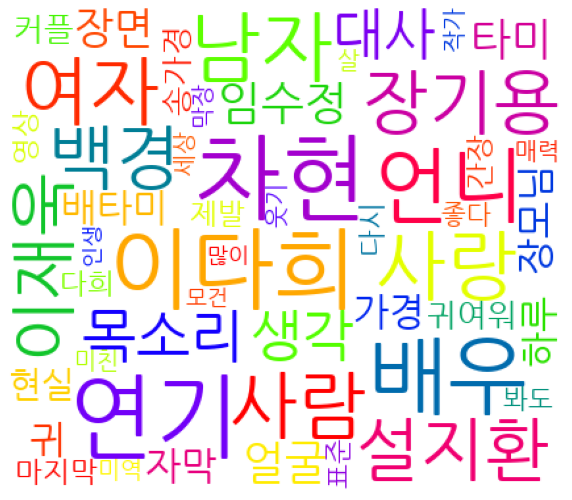

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.imshow(cloud)
plt.axis('off')

In [18]:
cloud.to_file('WWW_word_cloud.png')

### 감성분석- 네이버 영화 리뷰 데이터로 부터 학습

In [19]:
# urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
# urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

In [20]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [21]:
train_data = pd.concat([train_data, test_data], axis=0)

In [22]:
train_data.drop('id', axis=1, inplace=True)

In [23]:
train_data

,document,label
0,아 더빙.. 진짜 짜증나네요 목소리,0
1,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,너무재밓었다그래서보는것을추천한다,0
3,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...
49995,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
49996,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO,0
49997,그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다,0
49998,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,0


In [24]:
train_data.drop_duplicates(subset=['document'], inplace=True)

In [25]:
train_data = train_data.dropna(how = 'any')

In [26]:
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

In [27]:
train_data['document'] = train_data['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
train_data['document'].replace('', np.nan, inplace=True)

In [28]:
train_data.dropna(inplace=True)

In [29]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [30]:
twitter = Twitter()
characters = ['배타미', '타미', '차현', '송가경', '가경', '박모건', '모건', '설지환', '지환',
             '오진우', '진우', '민홍주', '홍주']
actors = ['임수정', '수정', '이다희', '다희', '전혜진', '혜진', '장기용', '기용',
          '이재욱', '재욱', '송가경', '가경', '권해효']
for character in characters:
    twitter.add_dictionary(character, 'Noun')
for actor in actors:
    twitter.add_dictionary(actor, 'Noun')

In [32]:
# 토큰화 및 불용어 제거
X_train = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = twitter.morphs(sentence) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

100%|██████████| 193518/193518 [06:57<00:00, 463.20it/s]


In [33]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [34]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [35]:
threshold = 4
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 89740
등장 빈도가 3번 이하인 희귀 단어의 수: 62094
단어 집합에서 희귀 단어의 비율: 69.19322487185202
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.594583714454944


In [36]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 27647


In [37]:
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)

In [38]:
y_train = np.array(train_data['label'])

In [39]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [40]:
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

193091
193091


리뷰의 최대 길이 : 71
리뷰의 평균 길이 : 11.893832441698473


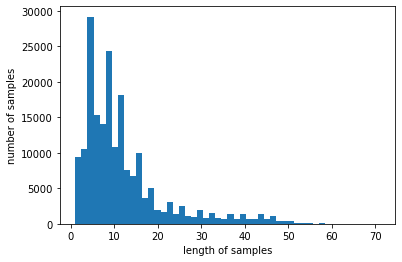

In [41]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [42]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [43]:
max_len = 20
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 20 이하인 샘플의 비율: 86.30334919804652


In [44]:
X_train = pad_sequences(X_train, maxlen=max_len)

In [45]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [46]:
embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
2413/2414 [============================>.] - ETA: 0s - loss: 0.3861 - acc: 0.8244
Epoch 1: val_acc improved from -inf to 0.84057, saving model to best_model.h5
2414/2414 [==============================] - 139s 56ms/step - loss: 0.3861 - acc: 0.8243 - val_loss: 0.3566 - val_acc: 0.8406
Epoch 2/15
2413/2414 [============================>.] - ETA: 0s - loss: 0.3207 - acc: 0.8626
Epoch 2: val_acc improved from 0.84057 to 0.85375, saving model to best_model.h5
2414/2414 [==============================] - 155s 64ms/step - loss: 0.3206 - acc: 0.8626 - val_loss: 0.3402 - val_acc: 0.8538
Epoch 3/15
2414/2414 [==============================] - ETA: 0s - loss: 0.2918 - acc: 0.8786
Epoch 3: val_acc improved from 0.85375 to 0.85429, saving model to best_model.h5
2414/2414 [==============================] - 171s 71ms/step - loss: 0.2918 - acc: 0.8786 - val_loss: 0.3329 - val_acc: 0.8543
Epoch 4/15
2413/2414 [============================>.] - ETA: 0s - loss: 0.2709 - acc: 0.8879
Epoch 4: v

### WWW 감성분석 진행

In [47]:
data = []
for sentence in all_data['comment']:
    tokenized_sentence = twitter.morphs(sentence)
    stopwords_removed = [word for word in tokenized_sentence if not word in stopwords]
    data.append(stopwords_removed)

In [48]:
loaded_model = load_model('best_model.h5')

In [49]:
def sentiment_predict(new_sentence):
    encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
    score = float(loaded_model.predict(pad_new)) # 예측
    return score

In [50]:
good, neutral, bad = 0,0,0
for comment in data:
    score = sentiment_predict(comment)
    if score < 0.4:
        bad += 1
    elif score <= 0.6:
        neutral += 1
    else:
        good += 1
positive_percent = round((good / (good + neutral + bad)), 4) * 100
neutral_percent = round((neutral / (good + neutral + bad)),4) * 100
negative_percent = round((bad / (good + neutral + bad)),4) * 100

1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 59ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 54ms/step


1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 54ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 45ms/step


In [51]:
print(f'긍정리뷰의 비율은 {positive_percent} % 입니다.')
print(f'중립리뷰의 비율은 {neutral_percent} % 입니다.')
print(f'부정리뷰의 비율은 {negative_percent} % 입니다.')

긍정리뷰의 비율은 49.29 % 입니다.
중립리뷰의 비율은 14.32 % 입니다.
부정리뷰의 비율은 36.38 % 입니다.
